In [143]:
import os.path

from revscoring import Model


model_path = os.path.expanduser("~/editquality/models/enwiki.damaging.gradient_boosting.model")
sm = Model.load(open(model_path), error_on_env_check=False)

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - platform 'Linux-4.9.0-6-amd64-x86_64-with-debian-9.4' mismatch with original environment 'Linux-4.16.0-x86_64-with-debian-9.4'
 - revscoring_version '2.2.2' mismatch with original environment '2.2.5'
 - release '4.9.0-6-amd64' mismatch with original environment '4.16.0'
 - version '#1 SMP Debian 4.9.82-1+deb9u3 (2018-03-02)' mismatch with original environment '#1 SMP Wed Apr 18 14:02:11 PDT 2018'


In [144]:
import mwapi
from revscoring.extractors import api

extractor = api.Extractor(mwapi.Session("https://en.wikipedia.org", user_agent="ORES-LIME demo"))

In [145]:
import numpy as np

rev_to_score = 12345
feature_values = np.array(list(extractor.extract(rev_to_score, sm.features)))
sm.score(feature_values)
feature_values

array([1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 5.71042702e+00,
       4.73619845e+00, 3.76120012e+00, 0.00000000e+00, 0.00000000e+00,
       1.60943791e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.16666667e+00, 3.71681416e-01, 0.00000000e+00, 1.06194690e-01,
       8.00000000e+00, 8.00000000e+00, 0.00000000e+00, 1.60000000e+00,
       1.60000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.48000000e+02, 2.14000000e+02,
       6.90000000e+01, 6.90000000e+01, 0.00000000e+00, 0.00000000e+00,
       4.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.90000000e+01,
       1.90000000e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [21]:
# Load training set
from revscoring.utilities.util import read_observations

observations = list(read_observations(open(os.path.expanduser("~/editquality/datasets/enwiki.labeled_revisions.w_cache.20k_2015.json"))))

In [131]:
# Transform training data into a numpy matrix.
import numpy as np

# FIXME: Don't cast booleans to float.

features = [str(f) for f in sm.features]
train = np.array([np.array([o["cache"][k] for k in features]) for o in observations])

In [135]:
# TODO: Also explain as text, using our own explainer to run variations.

from sklearn.linear_model import LinearRegression
from lime.lime_tabular import LimeTabularExplainer

def score(samples):
    raw_results = [np.array([sm.score(v)["probability"][t] for t in [False, True]]) for v in samples]
    return np.array(raw_results)

explainer = LimeTabularExplainer(
    train,
    mode="classification",
    feature_names=features,
    class_names=["not damaging", "damaging"],
    discretize_continuous=False
)

In [140]:
list(zip(features, feature_values))

[('feature.revision.page.is_articleish', 1.0),
 ('feature.revision.page.is_mainspace', 1.0),
 ('feature.revision.page.is_draftspace', 0.0),
 ('feature.log((wikitext.revision.parent.chars + 1))', 5.71042701737487),
 ('feature.log((AggregatorsScalar(<datasource.tokenized(datasource.revision.parent.text)>) + 1))',
  4.736198448394496),
 ('feature.log((AggregatorsScalar(<datasource.wikitext.revision.parent.words>) + 1))',
  3.7612001156935624),
 ('feature.log((AggregatorsScalar(<datasource.wikitext.revision.parent.uppercase_words>) + 1))',
  0.0),
 ('feature.log((wikitext.revision.parent.headings + 1))', 0.0),
 ('feature.log((wikitext.revision.parent.wikilinks + 1))', 1.6094379124341003),
 ('feature.log((wikitext.revision.parent.external_links + 1))', 0.0),
 ('feature.log((wikitext.revision.parent.templates + 1))', 0.0),
 ('feature.log((wikitext.revision.parent.ref_tags + 1))', 0.0),
 ('feature.revision.parent.chars_per_word', 7.166666666666667),
 ('feature.revision.parent.words_per_token'

In [136]:
exp = explainer.explain_instance(
    np.array(feature_values),
    score,
    num_features=10,
    top_labels=10,
    model_regressor=LinearRegression()
)

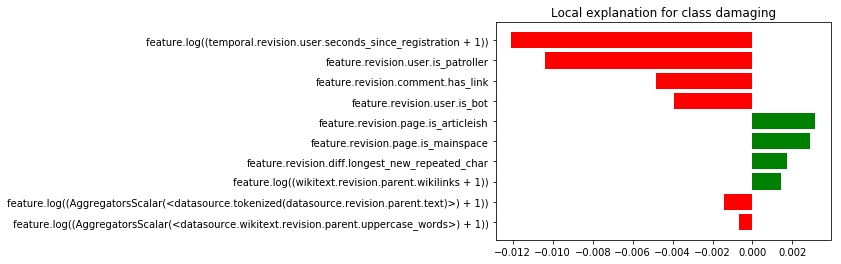

In [137]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [122]:
exp.as_list()

[('feature.log((temporal.revision.user.seconds_since_registration + 1)) <= 14.98',
  0.09945282539734833),
 ('feature.revision.user.is_patroller <= 0.00', 0.04699259895611817),
 ('feature.revision.user.is_bot <= 0.00', 0.028144618006953996),
 ('feature.revision.comment.has_link <= 0.00', 0.024358653170089735),
 ('0.00 < feature.revision.page.is_articleish <= 1.00', 0.016670733139106258)]

In [110]:
[sm.score(feature_values)["probability"][t] for t in [False, True]]

[0.9006672855880219, 0.09933271441197815]